In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os
from numpy import array
import tensorflow as tf
import time

Using TensorFlow backend.


In [4]:
np.random.seed(7)
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

In [12]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [9]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
print(X_train.shape)


(200, 6, 1)


In [14]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,4):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
time taken for execution : 2123.4162039756775 seconds 
Mean Validation loss= 0.02347994


# 2. Dow Jones Index:

In [15]:
#Convert Date Format:
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

#merge values:
gm_dates = list(gm.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(gm_dates))
gm["dow"] = mean_dow
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    #print(date)
    if date in dow_dates:
        gm["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))

del gm['Adj Close']
gm

198.285659767141 1259


,Open,High,Low,Close,Volume,dow
Date,,,,,,
2015-05-15,0.620900,0.582270,0.648933,0.610175,0.120612,209.91
2015-05-18,0.630030,0.590426,0.653711,0.614892,0.129499,212.63
2015-05-19,0.636794,0.591489,0.657216,0.617251,0.121978,213.62
2015-05-20,0.639161,0.593617,0.647658,0.613881,0.175782,213.01
2015-05-21,0.631045,0.606383,0.658490,0.632749,0.229963,211.42
...,...,...,...,...,...,...
2020-05-08,0.227596,0.192908,0.277795,0.240229,0.239541,237.39
2020-05-11,0.233683,0.171277,0.263141,0.202156,0.242902,244.15
2020-05-12,0.224890,0.167021,0.261867,0.194070,0.162761,244.85


In [16]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_dow = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_dow.fit(np.array(data['dow']).reshape(-1, 1))
    data['dow'] =scaler_dow.transform(np.array(data['dow']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [17]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1613.9131770133972 seconds 
Mean Validation loss= 0.02336529


# 3. FTSE opening Index:

In [5]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    #print(year+'-'+month+'-'+day)
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)
ftse

#merge values:
gm_dates = list(gm.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
print(mean_ftse,len(gm_dates))
gm["ftse"] = mean_ftse
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    #print(date)
    if date in ftse_dates:
        gm["ftse"][row_num] = mean((ftse['newOpen'][ftse['FormatDate']==date]))
    
del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


6982.075098814229 1259


,Open,High,Low,Close,Volume,ftse
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,6973.000000
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,6960.000000
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,6968.000000
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,6995.000000
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,7007.000000
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,6982.075099
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,5936.000000
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,5939.000000


In [22]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [23]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1549.7736988067627 seconds 
Mean Validation loss= 0.02249536


In [24]:
actual_out = np.empty([len(actual_high), 3])
predicted_out = np.empty([len(actual_high), 3])
for i in range(0,len(actual_high)):
    actual_out[i]= actual_high[i]
    predicted_out[i] = predicted_high[i]
mean(val_loss)

0.022495363333333334

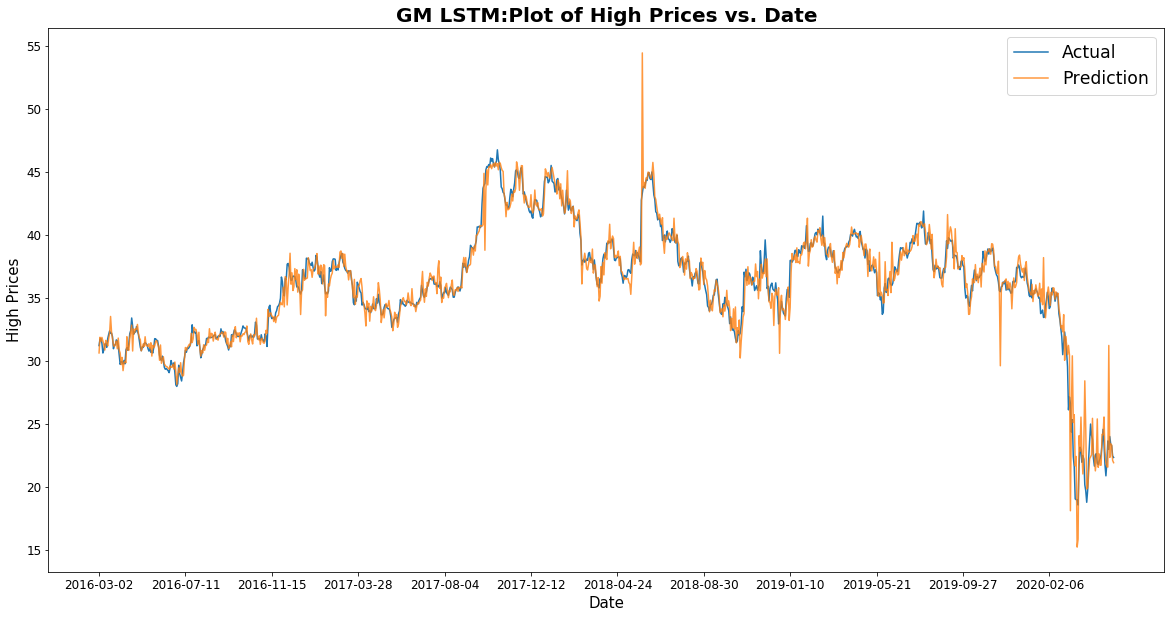

In [26]:
def evaluate_model(actual,predicted,dates,title_str,y_label):

    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel(y_label,fontsize=15)
    plt.plot((actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual_high= scaler_high.inverse_transform(np.array(actual_out[:,0]).reshape(-1,1))
predicted_high = scaler_high.inverse_transform(np.array(predicted_out[:,0]).reshape(-1,1))

actual_low= scaler_low.inverse_transform(np.array(actual_out[:,1]).reshape(-1,1))
predicted_low = scaler_low.inverse_transform(np.array(predicted_out[:,1]).reshape(-1,1))

actual_close= scaler_close.inverse_transform(np.array(actual_out[:,2]).reshape(-1,1))
predicted_close = scaler_close.inverse_transform(np.array(predicted_out[:,2]).reshape(-1,1))
title_str = 'GM LSTM:Plot of High Prices vs. Date'
y_label = 'High Prices'
evaluate_model(actual_high,predicted_high ,np.array(predicted_dates),title_str,y_label )
#actual_low,predicted_low,actual_close,predicted_close)



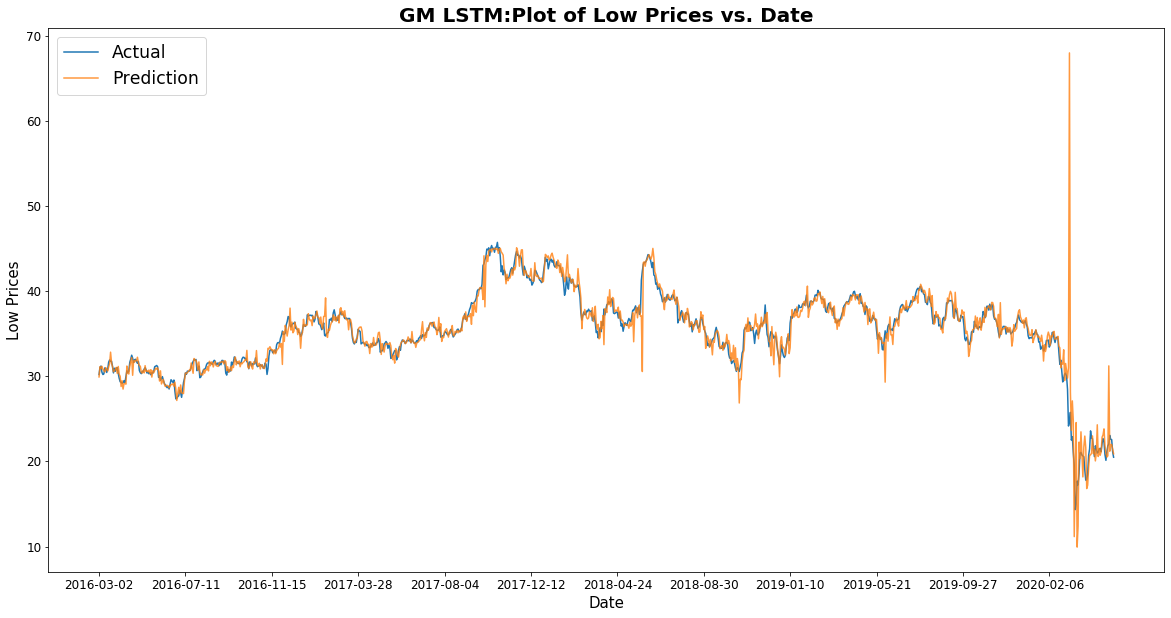

In [27]:
title_str = 'GM LSTM:Plot of Low Prices vs. Date'
y_label = 'Low Prices'
evaluate_model(actual_low,predicted_low ,np.array(predicted_dates),title_str,y_label )

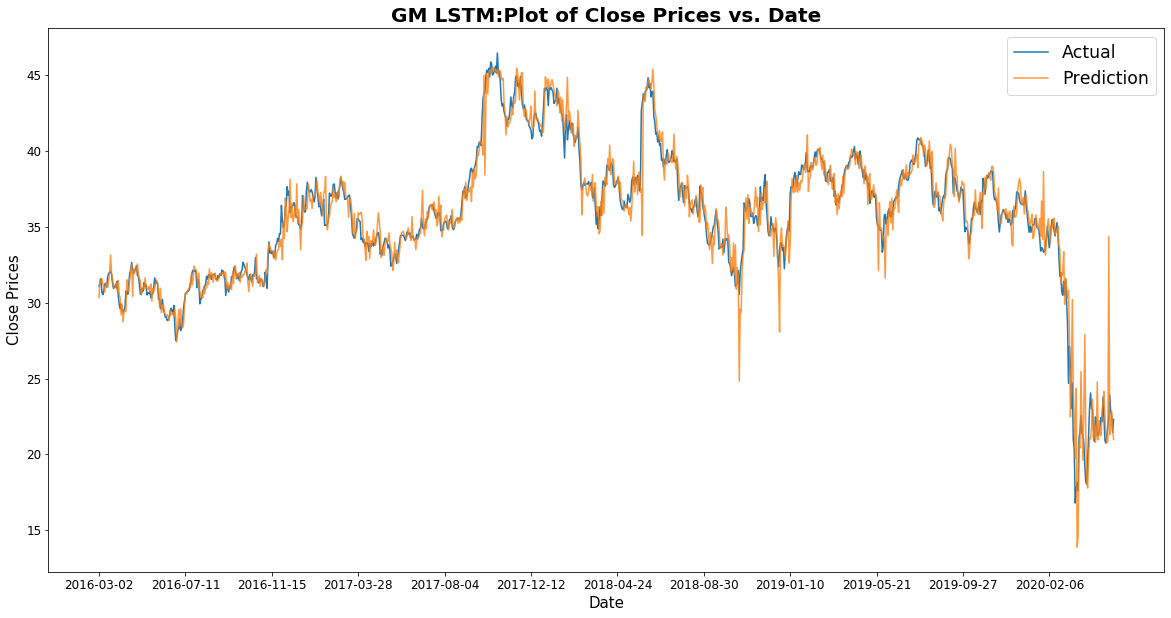

In [29]:
title_str = 'GM LSTM:Plot of Close Prices vs. Date'
y_label = 'Close Prices'
evaluate_model(actual_close,predicted_close ,np.array(predicted_dates),title_str,y_label )

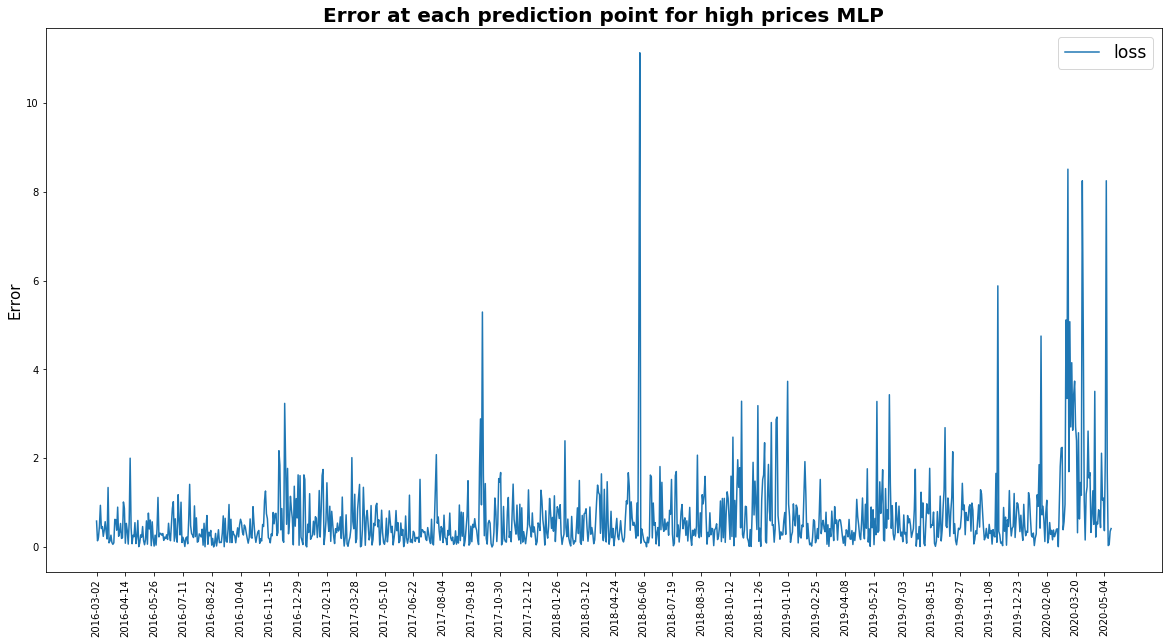

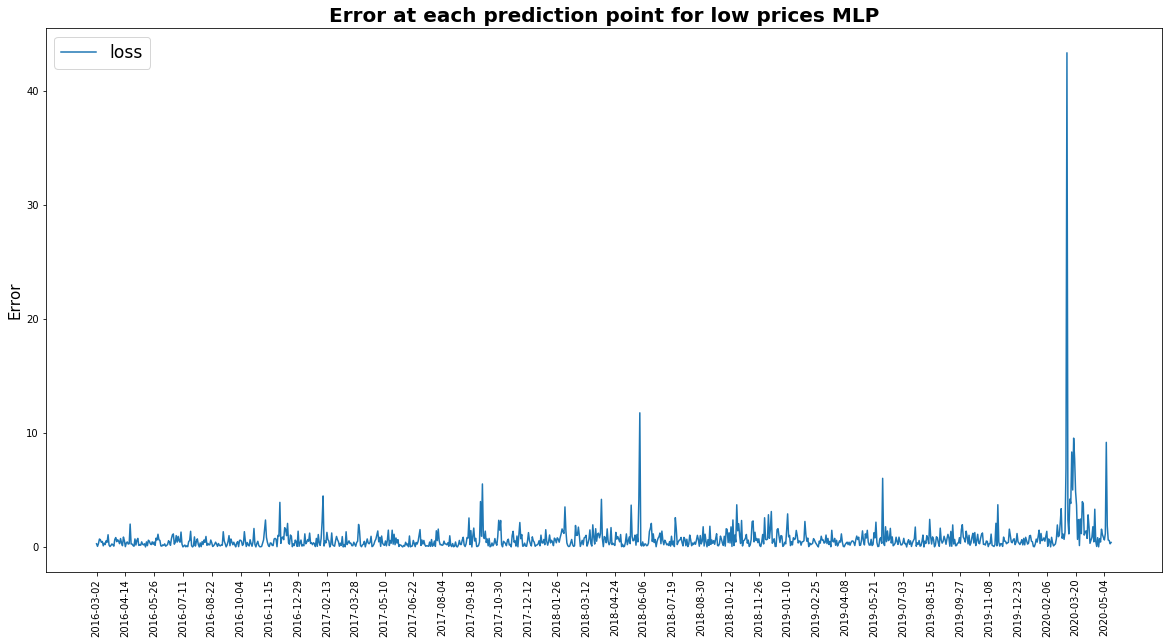

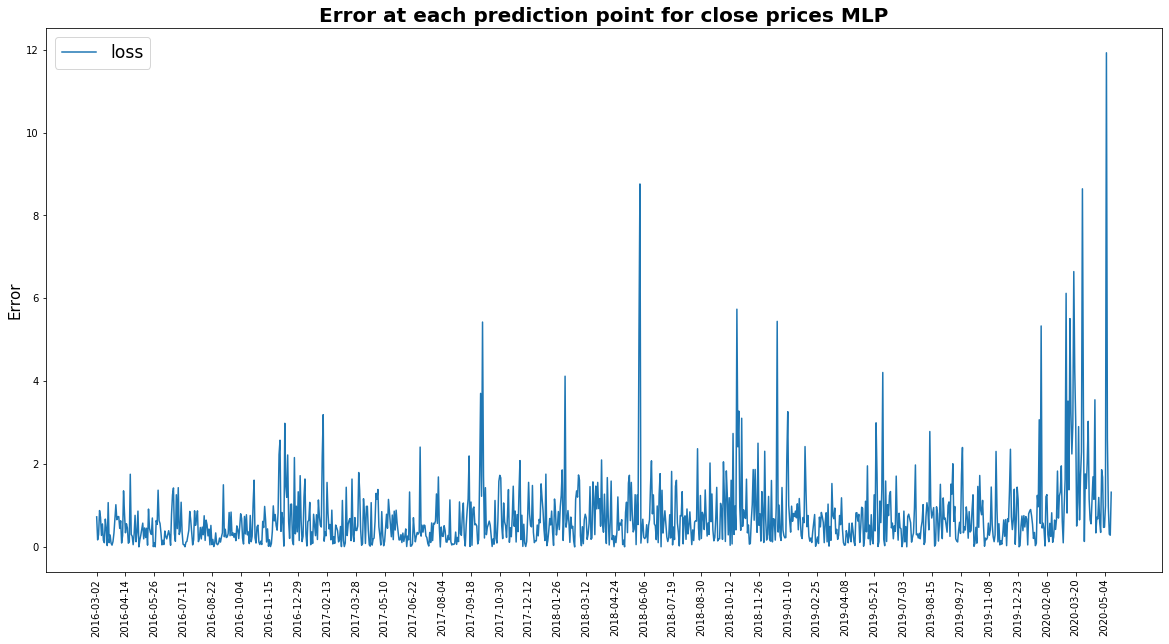

In [30]:

def mae(y_predicted,y_actual,dates,title_str):
    n = len(y_predicted)
    loss = []
    for i in range(0,n):
        loss.append(abs(y_predicted[i] - y_actual[i]))
    index = np.arange((len(loss)),step=30)
    
    plt.figure(figsize=(20,10))
    plt.title(title_str,fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    plt.xticks(index,dates[index],rotation=90)
    plt.plot((np.array(loss).reshape(-1,1)), label="loss")
    plt.legend(fontsize="xx-large")

title_str ='Error at each prediction point for high prices MLP'
mae(predicted_high,actual_high,np.array(predicted_dates),title_str)
title_str ='Error at each prediction point for low prices MLP'
mae(predicted_low,actual_low,np.array(predicted_dates),title_str)
title_str ='Error at each prediction point for close prices MLP'
mae(predicted_close,actual_close,np.array(predicted_dates),title_str)

<BarContainer object of 86 artists>

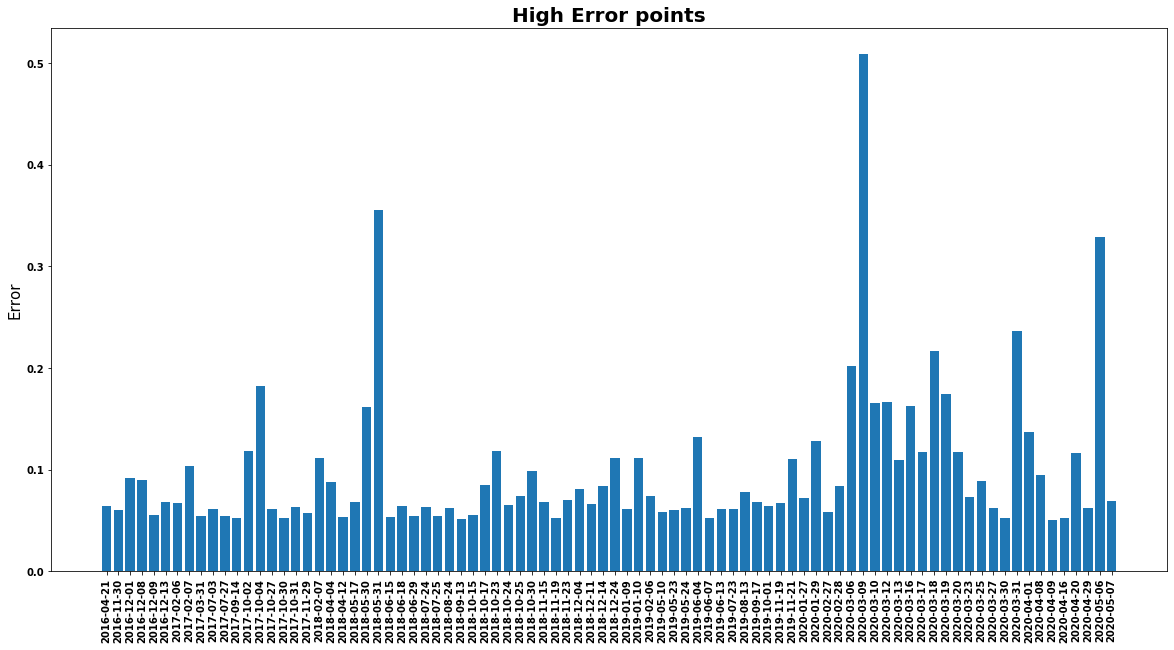

In [31]:

    large_loss = []
    large_loss_date = []
    for index in range(0,len(model_val_loss)):
        val_loss = model_val_loss[index]
        if val_loss>0.05:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
            large_loss.append(val_loss)
            large_loss_date.append(predicted_dates[index])


    plt.rcParams["font.weight"] = "bold"
    plt.figure(figsize=(20,10))
    plt.title('High Error points',fontsize=20,fontweight='bold')
    plt.ylabel('Error',fontsize=15)
    idx = np.arange(len(large_loss_date))
    plt.xticks(idx,large_loss_date,rotation=90)
    plt.bar(idx, large_loss, align='center', alpha=1)

# 4. S&P Global Oil Index:

In [6]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0)
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)
glb_oil 

#merge values:
gm_dates = list(gm.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
gm["oil"] = mean_oil
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in oil_dates:
        gm["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
    
del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,oil
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,1956.93
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,1948.25
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,1917.52
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,1916.57
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,1936.78
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,1082.50
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,1071.49
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,1062.24


In [7]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [10]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1616.2987790107727 seconds 
Mean Validation loss= 0.02330612


# 5. S&P1000 Index:

In [11]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
gm["S&P1000"] = mean_sp
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in sp1000_dates:
        gm["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))
del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,S&P1000
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,8627.79
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,8701.63
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,8689.52
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,8692.93
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,8697.50
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,9409.29
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,9309.29
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,8976.31


In [12]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #s&p 1000:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))

In [13]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1635.735352754593 seconds 
Mean Validation loss= 0.02306435


# 6. Crude Oil Prices:

In [14]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
gm["CrudeOil"] = mean_cop
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in cr_oil_dates:
        gm["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))

del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,CrudeOil
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,59.69
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,59.43
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,57.26
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,58.98
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,60.72
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,24.74
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,24.14
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,25.78


In [15]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #s&p 1000:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
 
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [16]:
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1586.1808609962463 seconds 
Mean Validation loss= 0.02224933


# 7. Dow Jones Oil & Gas Supersector Titans Index:

In [18]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)

#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)

#merge values:
gm_dates = list(gm.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
gm["TitanOil"] = mean_top
for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num] 
    if date in titan_oil_dates:
        gm["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Volume,TitanOil
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,445.40
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,443.20
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,437.01
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,437.22
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,441.62
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,267.26
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,265.18
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,262.17


In [20]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #S&P Supersector Oil Titans:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [21]:
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1620.8198792934418 seconds 
Mean Validation loss= 0.02197948


# 8. Car Sales Data:

In [25]:
gm = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/General Motors 5 years.csv', header=0, index_col=0) 
gm_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/GMSales.csv', header=0, index_col=None)
gm_sales

#merge values:
gm_dates = list(gm.index)
sales_dates = list(gm_sales['Month'])
gm["sales"] = 0

for row_num in range(0,len(gm_dates)):
    date = gm_dates[row_num][0:7] 
    #print(date,gm_dates[row_num][0:7] )
    #print(date,gm_sales['Sales'][gm_sales['Month']==date])
    gm["sales"][row_num] = gm_sales['Sales'][gm_sales['Month']==date]
        
del gm['Adj Close']
gm

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,Volume,sales
Date,,,,,,
2015-05-15,34.700001,34.980000,34.700001,34.910000,9778800,292053
2015-05-18,34.970001,35.209999,34.849998,35.049999,10285700,292053
2015-05-19,35.169998,35.240002,34.959999,35.119999,9856700,292053
2015-05-20,35.240002,35.299999,34.660000,35.020000,12925600,292053
2015-05-21,35.000000,35.660000,35.000000,35.580002,16016000,292053
...,...,...,...,...,...,...
2020-05-08,23.070000,24.000000,23.049999,23.930000,16562300,196377
2020-05-11,23.250000,23.389999,22.590000,22.799999,16754000,196377
2020-05-12,22.990000,23.270000,22.549999,22.559999,12182900,196377


In [26]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sales = MinMaxScaler()
   
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(data['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    #fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    #data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #S&P Supersector Oil Titans:
    fit = scaler_sales.fit(np.array(data['sales']).reshape(-1, 1))
    data['sales'] =scaler_sales.transform(np.array(data['sales']).reshape(-1, 1))
    
    return data,scaler_high,scaler_low,scaler_close
    
df = gm
dataframe_gm = df
df,scaler_high,scaler_low,scaler_close = normalize(df)

#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High','Low','Close']]
yarr = df1.rename_axis('ID').values
yarr = yarr[1:1259]

In [27]:
Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
callbacks = [early_stopping, callback_checkpoint]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(3))
model.compile(loss="mean_absolute_error", optimizer=adam)
#window size =1:
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,3):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
time taken for execution : 1619.978893995285 seconds 
Mean Validation loss= 0.02434223
